<h2>Table of Contents</h2>
<p>In this lab, you will use a single layer Softmax to classify handwritten digits from the MNIST database.</p>

<ul>
    <li><a href="#Makeup_Data">Make some Data</a></li>
    <li><a href="#Classifier">Softmax Classifier</a></li>
    <li><a href="#Model">Define Softmax, Criterion Function, Optimizer, and Train the Model</a></li>
    <li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>


In [3]:
# Import the libraries we need for this lab

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [4]:
torch.__version__

'1.7.0+cu101'

In [5]:
# The function to plot parameters

def PlotParameters(model): 
    W = model.state_dict()['linear.weight'].data
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            
            # Set the label for the sub-plot.
            ax.set_xlabel("class: {0}".format(i))

            # Plot the image.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
    plt.show()

In [13]:
# Plot the data

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

In [7]:
# Create and print the training dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
# Create and print the validating dataset

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print("Print the validating dataset:\n ", validation_dataset)

Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [10]:
# Print the type of the element

print("Type of data element: ", type(train_dataset[0][1]))

Type of data element:  <class 'int'>


Each element in the rectangular tensor corresponds to a number that represents a pixel intensity as demonstrated by the following image:

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.32_image_values.png" width="550" alt="MNIST elements" />


In [11]:
# Print the label

print("The label: ", train_dataset[3][1])

The label:  1


The image:  None


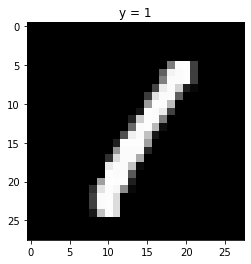

In [14]:
# Plot the image

print("The image: ", show_data(train_dataset[3]))

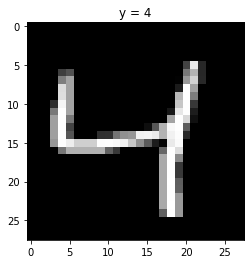

In [15]:
# Plot the image

show_data(train_dataset[2])

## Buld a Softmax Classifier

In [16]:
# Define softmax classifier class

class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        z = self.linear(x)
        return z

In [17]:
# Print the shape of train dataset

train_dataset[0][0].shape

torch.Size([1, 28, 28])

Flatten the tensor as shown in this image: 
<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.3.2image_to_vector.gif" width="550" alt="Flattern Image" />


In [18]:
# Set input size and output size

input_dim = 28 * 28
output_dim = 10

In [19]:
# Create the model

model = SoftMax(input_dim, output_dim)
print("Print the model:\n ", model)

Print the model:
  SoftMax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [20]:
# Print the parameters

print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([10, 784])
b:  torch.Size([10])


You can cover the model parameters for each class to a rectangular grid:  

<a>     <img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.3.2paramaters_to_image.gif" width = 550, align = "center"></a> 



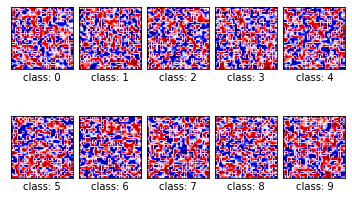

In [21]:
# Plot the model parameters for each class

PlotParameters(model)

In [22]:
# Define the learning rate, optimizer, criterion and data loader

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [23]:
# Train the model

n_epochs = 10
loss_list = []
accuracy_list = []
N_test = len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
        correct = 0
        # perform a prediction on the validationdata  
        for x_test, y_test in validation_loader:
            z = model(x_test.view(-1, 28 * 28))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)

train_model(n_epochs)

Analyze Results

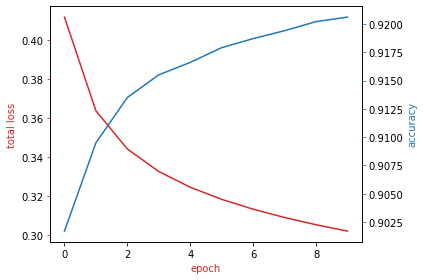

In [24]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

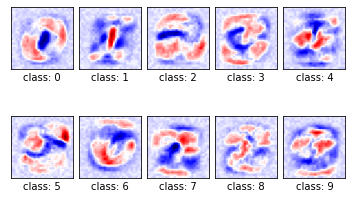

In [25]:
# Plot the parameters

PlotParameters(model)

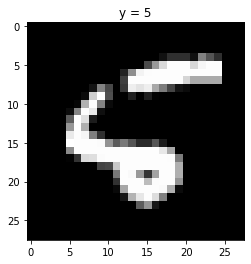

yhat: tensor([6])
probability of class  0.9901570081710815


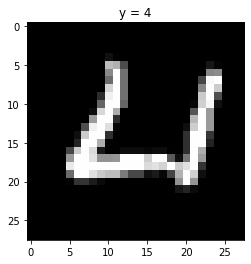

yhat: tensor([6])
probability of class  0.4488155245780945


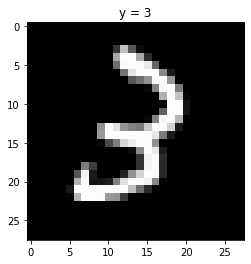

yhat: tensor([2])
probability of class  0.6773204803466797


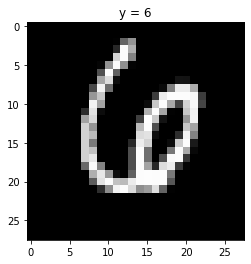

yhat: tensor([7])
probability of class  0.3339960277080536


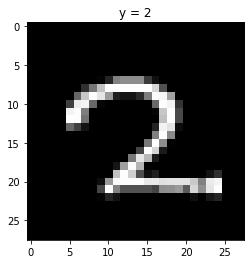

yhat: tensor([7])
probability of class  0.5301409959793091


In [26]:
# Plot the misclassified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break       

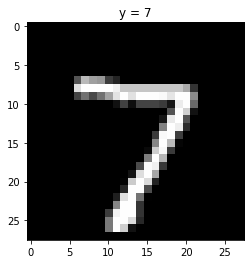

yhat: tensor([7])
probability of class  0.9967772364616394


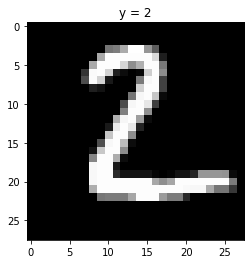

yhat: tensor([2])
probability of class  0.9503507018089294


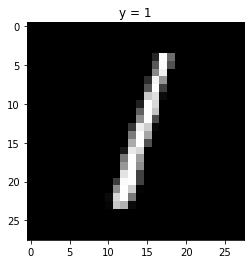

yhat: tensor([1])
probability of class  0.9745474457740784


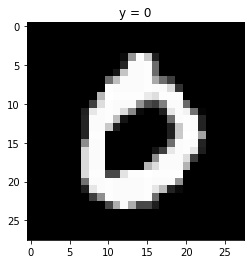

yhat: tensor([0])
probability of class  0.9995794892311096


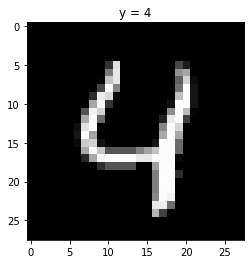

yhat: tensor([4])
probability of class  0.945862889289856


In [27]:
# Plot the classified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break  